In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from propagation import laser
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
plt.style.use('notes')

path = '/mnt/md0/Data/rariniello/Filamentation/Bessel_Beam/'
lam = 0.796
# All length units are in um

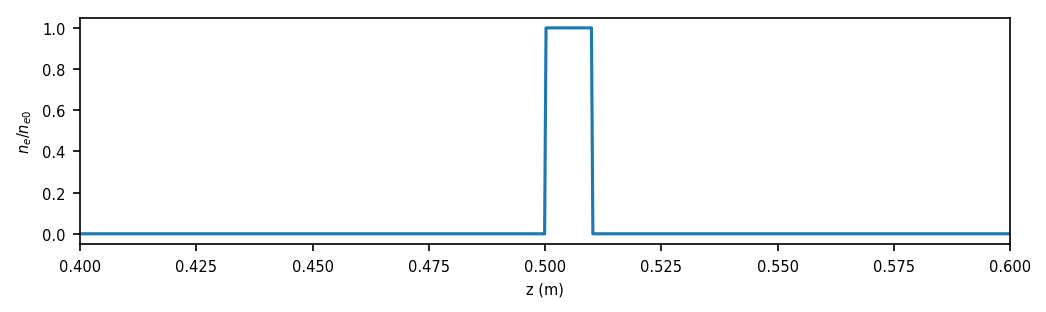

In [2]:
# Plasma density of 1e20
# Helium gas to minimize the effect of beam ionization
length = 10e3
width = 100

# Create the grid for the setup
Nz = 2**15
Z = 10e6 # Needs to be very large to provide resolution in the frequency domain
z, dz = np.linspace(0, Z, Nz, retstep=True)
frac_l = np.zeros(Nz, dtype='double')

# On axis plasma density profile is given by
# Uniform accelerating plasma
z0 = 0.5e6 # start of the uniform plasma
sel_u = np.logical_and(z > z0, z < z0+length)
frac_l[sel_u] = 1.0

xlim = [0.4, 0.6]
#xlim = [2.4, 4]
#xlim = [3.25, 4]
#xlim = [2, 2.5]
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, frac_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.xlim(xlim)
plt.show()

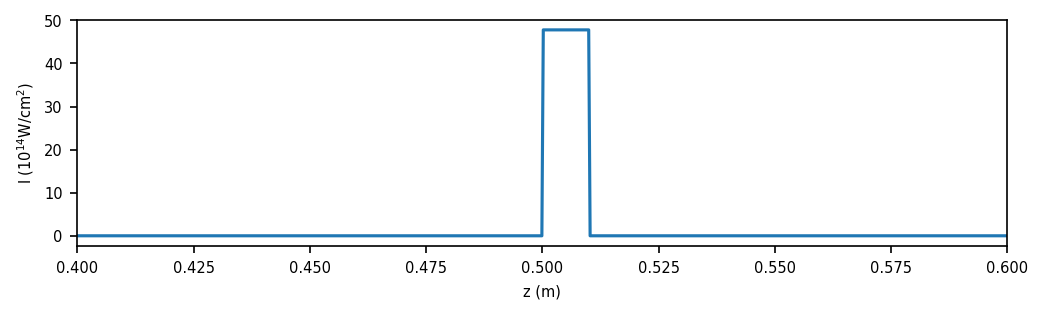

In [3]:
# Calculate the desired on axis intensity profile from the ionization fraction
# Assume a pulse with a Gaussian temporal shape
tau = 30 # RMS pulse length in fs
ion = {'atom' : ionization.He,
       'tau' : tau,
       'type' : 'gaussian'}
I_l = 2*ionization.intensity_from_density(ion, 0.999*frac_l)
sel = I_l < 1
I_l[sel] = 0.0

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()
# Double the calculated intensity to account for absorption by the laser during ionization

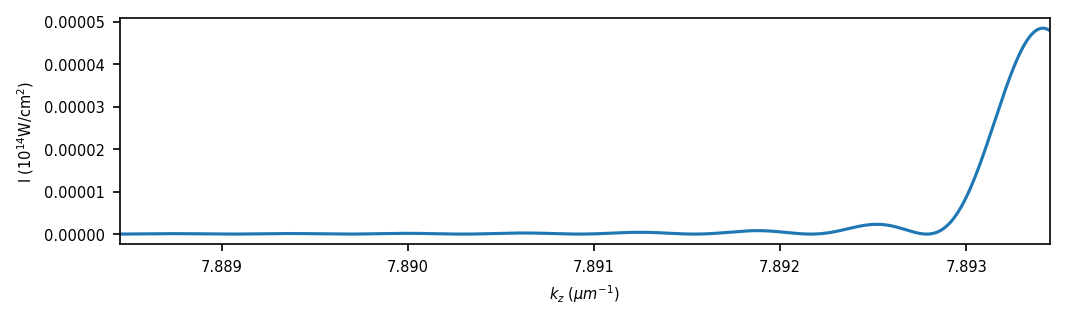

In [4]:
# Lets look at the spatial frequency componenets of the ramp
# The end of the plot is the maximum supported frequency
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 100,
    'lam' : lam
}
r = np.linspace(0, params['R'], params['Nr'])
E = np.zeros(params['Nr'], dtype='complex128')
Ez = ionization.field_from_intensity(I_l)
k = 2*np.pi/lam
dz = z[1] - z[0]
# Shift frequencies
kr0 = 2.4048 / params['w']
kz0 = np.sqrt(k**2 - kr0**2)
kz = 2*np.pi * fftshift(fftfreq(Nz, dz)) + kz0
e = fftshift(fft(Ez)) / Nz

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(kz, ionization.intensity_from_field(e))
plt.xlabel(r'$k_z$ ($\mu m^{-1}$)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(k-5e-3, k)
plt.show()

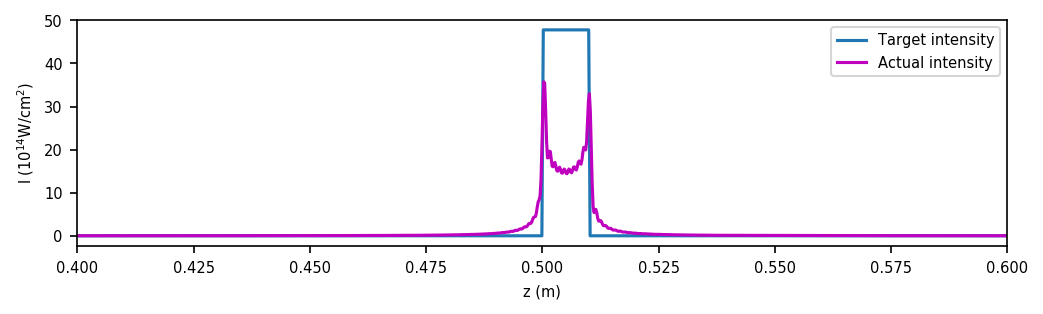

In [5]:
# Calculate the required intensity and phase profile after the beam shaping optics
r, E = bessel.bessel_expansion(params, z, I_l)
zFres = np.linspace(0.4e6, 0.6e6, 1000)
eFres = laser.fresnel_axis(E, r, zFres, lam)
IFres = ionization.intensity_from_field(eFres)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l)
plt.plot(zFres/1e6, IFres, 'm')
plt.legend(['Target intensity', 'Actual intensity'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

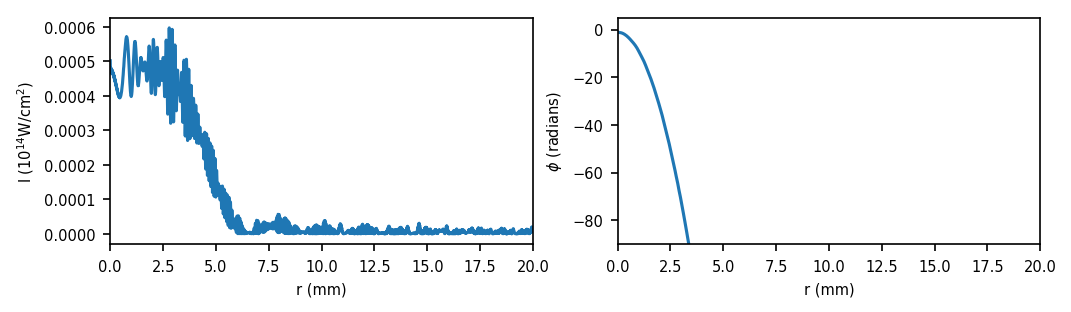

In [6]:
# Radial dependence of the phase and and intensity after the beam shaping optics
rlim = [0, 20]
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(r/1e3, ionization.intensity_from_field(E))
plt.xlabel(r'r (mm)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(rlim)
plt.subplot(122)
plt.plot(r/1e3, np.unwrap(np.angle(E)))
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(rlim)
plt.ylim(-90, 5)
plt.show()

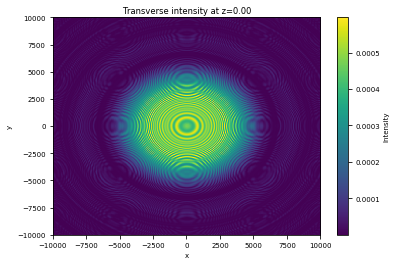

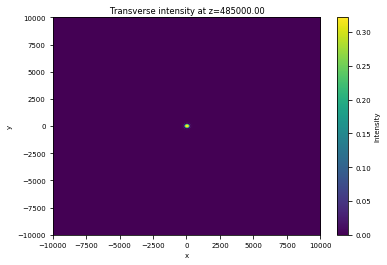

In [7]:
Nx = 2**12
X = 20e3

pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
beam0 = laserbeam.Laser(pulseParams)
e = beam0.reconstruct_from_cyl(r, E, beam0.x, beam0.y)
beam0.initialize_field(e)
beam0.plot_current_intensity()
beam0.propagate(0.485e6, 1.0)
beam0.plot_current_intensity()

In [8]:
print('Peak power %0.2f' % (beam0.total_cyl_power(r, ionization.intensity_from_field(7*E))))

Peak power 1.96


In [9]:
def plot_laser_plasma(I, ne, ext):
    plt.figure(figsize=(16, 4), dpi=300)
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    plt.show()

In [10]:
def refraction_field(ne0, X, Nx, Z, Nz, z0):
    z = np.linspace(0, Z, Nz)
    pulseParams = {
        'Nt' : 2**6,
        'Nx' : Nx,
        'Ny' : Nx,
        'X' : X,
        'Y' : X,
        'T' : 3*tau,
        'lam' : lam,
        'path' : path,
        'load' : False,
        'threads' : 20,
        'cyl' : True,
        'tau' : tau,
        'name' : 'Bessel_pulse'
    }
    plasmaParams = {
        'Nx' : Nx,
        'Ny' : Nx,
        'Nz' : Nz,
        'X' : X,
        'Y' : X,
        'Z' : Z,
        'atom' : ionization.He,
        'path' : path,
        'load' : False,
        'cyl' : True,
        'name' : 'Bessel_plasma',
        'n0' : ne0/1e17
    }

    ext = [z0/1e3, (Z+z0)/1e3, -X/2, X/2]
    pulse = laserpulse.Pulse(pulseParams)
    e = 7*pulse.rescale_field(beam0, pulse)[None, :, :]*np.exp(-pulse.t[:, None, None]**2*np.pi/(2*tau**2))
    pulse.initialize_field(e)
    helium = plasma.UniformPlasma(plasmaParams)
    interactions.pulse_plasma(pulse, helium)
    e = np.zeros((Nz, Nx), dtype='complex128')
    ne = np.zeros((Nz, Nx))
    for i in range(0, Nz-1):
        ne[i, :] = helium.load_plasma_density(i)[0]
    for i in range(Nz):
        e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
    I = ionization.intensity_from_field(e)
    ne = ne*1e17
    return I, ne, ext

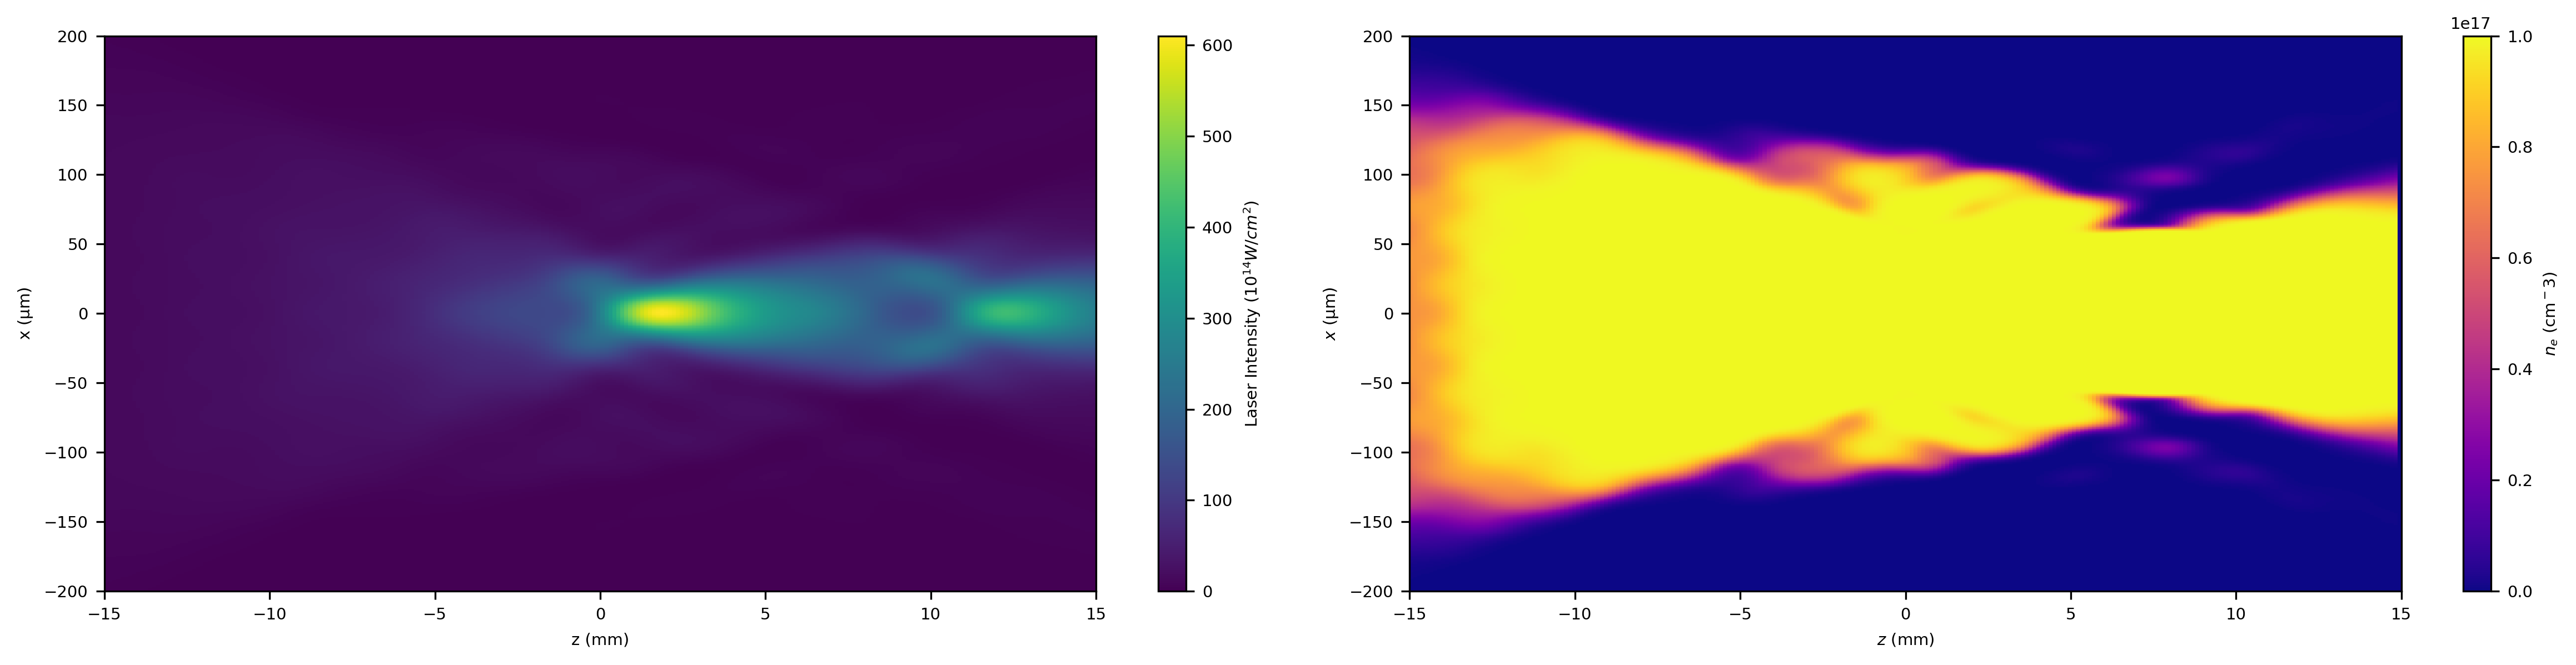

In [11]:
Nx = 2**10
X = 1200
Nz = 250
Z = 30e3
z0 = -15e3
ne0 = 1e17
I, ne, ext = refraction_field(ne0, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

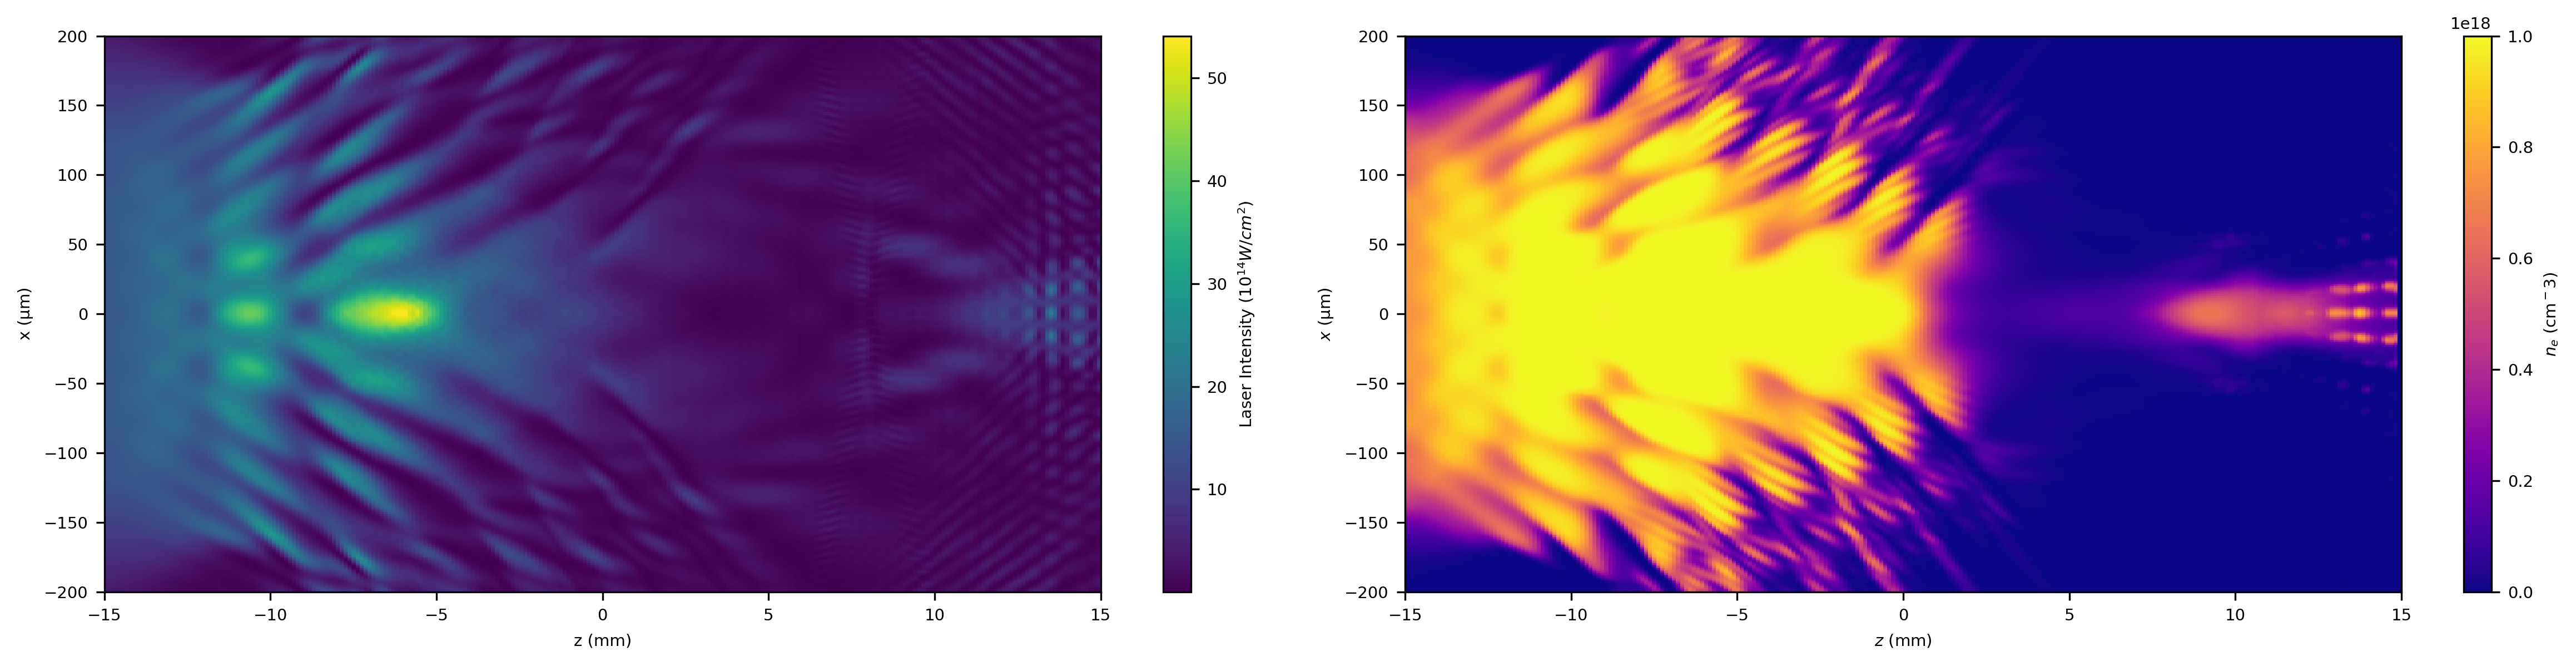

In [12]:
Nx = 2**10
X = 1200
Nz = 250
Z = 30e3
z0 = -15e3
ne0 = 1e18
I, ne, ext = refraction_field(ne0, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

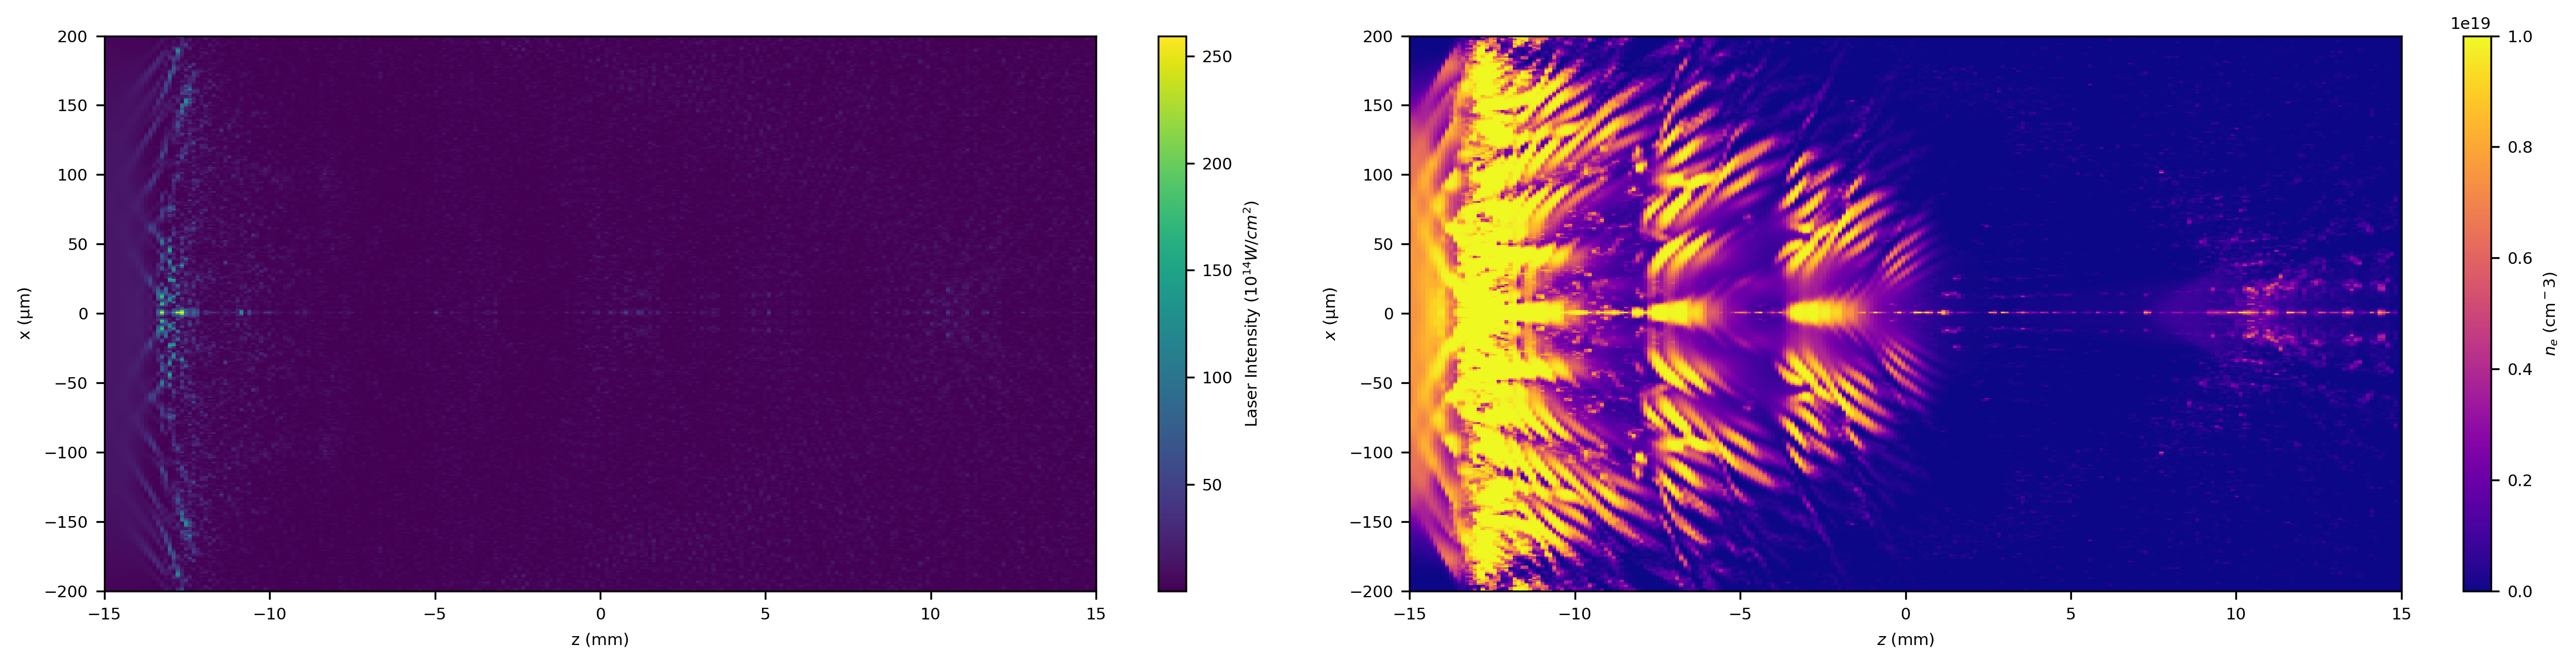

In [13]:
Nx = 2**10
X = 1200
Nz = 250
Z = 30e3
z0 = -15e3
ne0 = 1e19
I, ne, ext = refraction_field(ne0, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

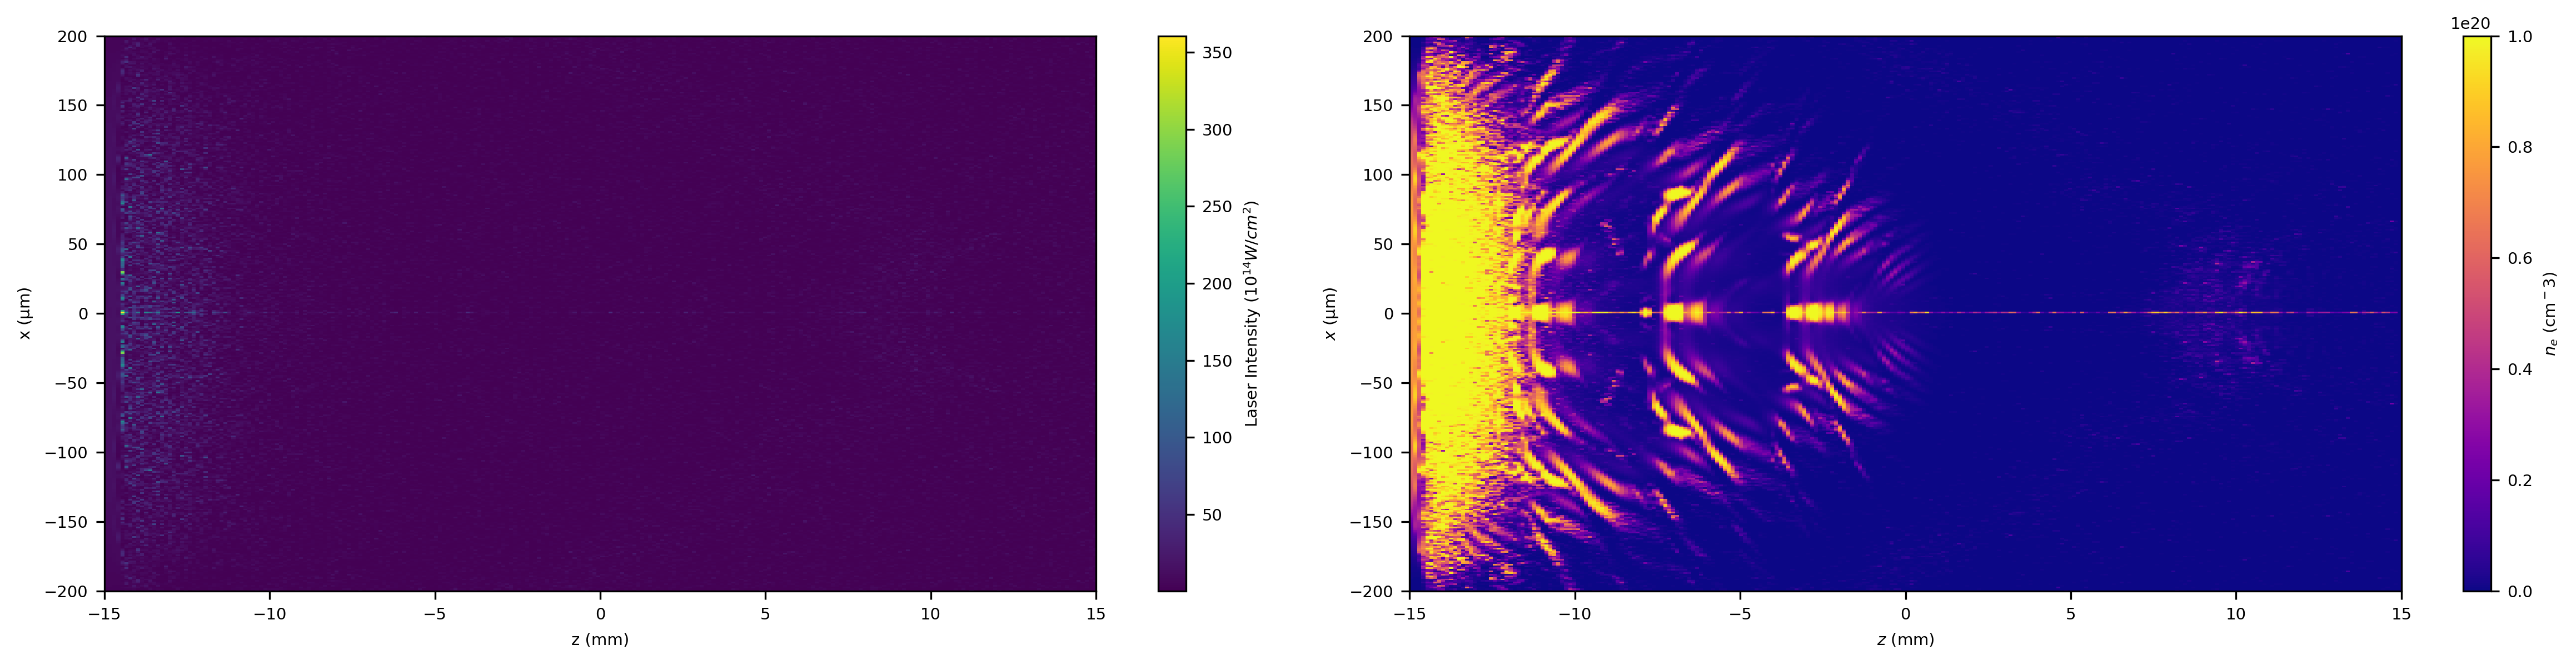

In [14]:
Nx = 2**10
X = 1200
Nz = 250
Z = 30e3
z0 = -15e3
ne0 = 1e20
I, ne, ext = refraction_field(ne0, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)